In [144]:
import torch
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import seaborn as sns

In [145]:
tl.set_backend('pytorch')

In [146]:
tensor = torch.load('data/tcga_tensor.pt')
tensor = torch.log1p(tensor)
genes = np.load("data/genes.npy", allow_pickle=True)
patients = np.load("data/patients.npy", allow_pickle=True)
sample_types = np.load("data/sample_types.npy", allow_pickle=True)

In [147]:
# === Subsample First 1000 Genes for Benchmark ===
subset_genes = 1000
tensor = tensor[:subset_genes, :, :]
tensor = torch.log1p(tensor)

In [148]:
mask_bool = ~torch.isnan(tensor)
mask_float = mask_bool.float()

In [149]:
# === Simulate Random Missingness (20% randomly masked from observed entries) ===
missing_fraction = 0.2
mask_train_bool = mask_bool.clone()
mask_train_float = mask_float.clone()

In [150]:
# Get indices of observed entries
observed_indices = torch.nonzero(mask_train_bool, as_tuple=False)
num_mask = int(len(observed_indices) * missing_fraction)
masked_idx = observed_indices[torch.randperm(len(observed_indices))[:num_mask]]

In [151]:
# Apply masking
mask_train_bool[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = False
mask_train_float[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = 0.0

In [152]:
# Ground truth for evaluation
tensor_filled = torch.where(mask_bool, tensor, torch.tensor(0.0, dtype=tensor.dtype))

In [153]:
# === Tucker Completion Function (random init for memory efficiency) ===
def tucker_completion(X_obs, mask, rank=(20, 20, 2), n_iter=500):
    # Run Tucker decomposition with mask
    core, factors = tucker(
        X_obs, rank,
        n_iter_max=n_iter,
        init='random',
        mask=mask,
        svd='numpy_svd'
    )
    return tucker_to_tensor((core, factors))

In [154]:
# === Run Completion ===
X_obs = torch.where(mask_train_bool, tensor, torch.tensor(0.0, dtype=tensor.dtype))
X_pred = tucker_completion(X_obs, mask_train_float, rank=(5, 5, 2), n_iter=500)

In [155]:
# === Evaluate Performance ===
def evaluate(true_tensor, pred_tensor, eval_mask):
    true_vals = true_tensor[eval_mask]
    pred_vals = pred_tensor[eval_mask]
    rmse = torch.sqrt(torch.mean((true_vals - pred_vals) ** 2)).item()
    mae = torch.mean(torch.abs(true_vals - pred_vals)).item()
    return rmse, mae

In [156]:
rmse, mae = evaluate(tensor, X_pred, ~mask_train_bool & mask_bool)
print(f"\nEvaluation on masked entries:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}")


Evaluation on masked entries:
RMSE: 0.1734
MAE: 0.0910


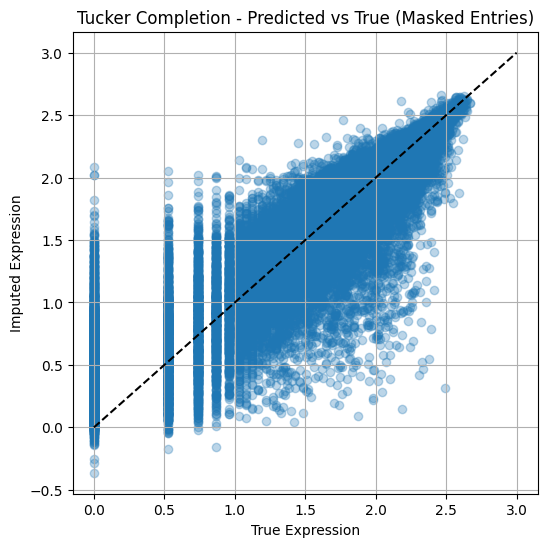

In [157]:
# === Visualizations ===
plt.figure(figsize=(6, 6))
plt.scatter(
    tensor[~mask_train_bool & mask_bool].cpu().numpy(),
    X_pred[~mask_train_bool & mask_bool].detach().cpu().numpy(),
    alpha=0.3
)
plt.xlabel("True Expression")
plt.ylabel("Imputed Expression")
plt.title("Tucker Completion - Predicted vs True (Masked Entries)")
plt.plot([0, 3], [0, 3], linestyle='--', color='black')
plt.grid(True)
plt.show()

In [158]:
fractions = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
rmse_scores = []
mae_scores = []

for frac in fractions:
    print(f"Testing with {int(frac * 100)}% simulated missingness...")

    # Reset masks
    mask_bool = ~torch.isnan(tensor)
    mask_train_bool = mask_bool.clone()
    mask_train_float = mask_bool.float()

    observed_idx = torch.nonzero(mask_bool, as_tuple=False)
    n_mask = int(len(observed_idx) * frac)
    masked_idx = observed_idx[torch.randperm(len(observed_idx))[:n_mask]]

    # Apply masking
    mask_train_bool[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = False
    mask_train_float[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = 0.0

    # Impute
    X_obs = torch.where(mask_train_bool, tensor, torch.tensor(0.0, dtype=tensor.dtype))
    X_pred = tucker_completion(X_obs, mask_train_float, rank=(20, 20, 2))

    # Evaluate
    rmse, mae = evaluate(tensor, X_pred, ~mask_train_bool & mask_bool)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

Testing with 5% simulated missingness...
Testing with 10% simulated missingness...
Testing with 15% simulated missingness...
Testing with 20% simulated missingness...
Testing with 25% simulated missingness...
Testing with 30% simulated missingness...
Testing with 35% simulated missingness...
Testing with 40% simulated missingness...
Testing with 45% simulated missingness...
Testing with 50% simulated missingness...
Testing with 55% simulated missingness...
Testing with 60% simulated missingness...
Testing with 65% simulated missingness...
Testing with 70% simulated missingness...
Testing with 75% simulated missingness...
Testing with 80% simulated missingness...


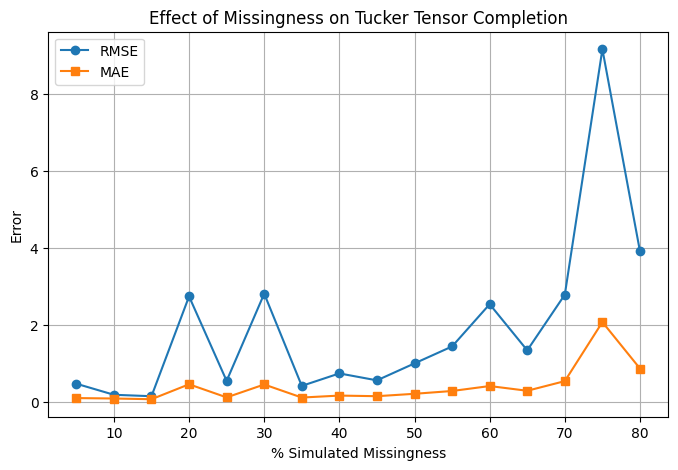

In [159]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot([int(f*100) for f in fractions], rmse_scores, label='RMSE', marker='o')
plt.plot([int(f*100) for f in fractions], mae_scores, label='MAE', marker='s')
plt.xlabel('% Simulated Missingness')
plt.ylabel('Error')
plt.title('Effect of Missingness on Tucker Tensor Completion')
plt.legend()
plt.grid(True)
plt.show()